# Try nanogpt on a prepared set of snips

This nanogpt model is trained on a txt file made of all precomputed snips (using freesound dataset).

In [67]:
!python data/slang_data/prepare.py

length of dataset in characters: 1,389,500
all the unique characters: 
0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyzÀÁÂÃÄÅÆÇÈÉÊËÌÍÎÏÐÑÒÓÔÕÖ×ØÙÚÛÜÝÞßàáâãäåæçèéêëìíîïðñòóôõö÷øùúûüýþÿĀāĂăĄąĆćĈĉĊċČčĎďđĒēĔĕĖėĘęĚěĜĝĞğĠġĢģĤĥĦħĨĩĪīĬĭĮįİıĲĳĴĵĶķĸĹĺĻļĽľĿŀŁłŃńŅņŇňŉŊŋŌōŎŏ
vocab size: 206
train has 1,250,550 tokens
val has 138,950 tokens


In [68]:
# This step has already been done: retrain only if needed, takes 4minutes.
!python train.py config/train_slang.py --device=cpu --compile=False --eval_iters=20 --log_interval=1 --block_size=64 --batch_size=12 --n_layer=4 --n_head=4 --n_embd=128 --max_iters=2000 --lr_decay_iters=2000 --dropout=0.0

Overriding config with config/train_slang.py:
# train a miniature character-level shakespeare model
# good for debugging and playing on macbooks and such

out_dir = 'out-slang'
eval_interval = 250  # keep frequent because we'll overfit
eval_iters = 200
log_interval = 10  # don't print too too often

# we expect to overfit on this small dataset, so only save when val improves
always_save_checkpoint = False

wandb_log = False  # override via command line if you like
wandb_project = 'shakespeare-char'
wandb_run_name = 'mini-gpt'

dataset = 'slang_data'
gradient_accumulation_steps = 1
batch_size = 64
# block_size = 256  # context of up to 256 previous characters
block_size = 64  # context of up to 256 previous characters


# baby GPT model :)
n_layer = 6
n_head = 6
n_embd = 384
dropout = 0.2

learning_rate = 1e-3  # with baby networks can afford to go a bit higher
max_iters = 5000
lr_decay_iters = 5000  # make equal to max_iters usually
min_lr = 1e-4  # learning_rate / 10 usually
beta2 = 0

## What to do with that model

## Generate some strings from the model

In [69]:
!python sample.py --out_dir=out-slang --device=cpu

Overriding: out_dir = out-slang
Overriding: device = cpu
number of parameters: 0.81M
Loading meta from data/slang_data/meta.pkl...

aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaÂaaaaaaaaaÂaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaÂaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
aÂaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaÂaaaaaaaaaaÂaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
ÙaÙÙÙaaaÂĉÙÂÂÂeaaaaaaaÂaaÂaaaaÂÂaaaaaaaaaaaaaaaaaÂÂĩÂÂaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaÙaaaaaaaÙaaÂÙaaaaaaŅÂaÂa
---------------



aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa

In [ ]:
# Sample texts generated
ÙaÙÙÙaaaÂĉÙÂÂÂeaaaaaaaÂaaÂaaaaÂÂaaaaaaaaaaaaaaaaaÂÂĩÂÂaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaÙaaaaaaaÙaaÂÙaaaaaaŅÂaÂa

ááŎÝooáááÂeÂaaÂĩeeaaaaX0VVĉÂÂÂÂÂÂÂÂáÂĩeeĩeÂÂÂÂÂeÂáÂÂaaaaaaaaaÂÂaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa

aaaaaaaaaaÂÂÂÂÂÂÂÂÂaÂÂÂÂaeaeeeÂeÂeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeaaaaaeeaaaaaaaaaeeaeeaeeeeeeeaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa

## Extract the model and get info about it

In [70]:
"""
Sample from a trained model
"""
import os
import pickle
from contextlib import nullcontext
import torch
import tiktoken
from model import GPTConfig, GPT

# -----------------------------------------------------------------------------
init_from = 'resume' # either 'resume' (from an out_dir) or a gpt2 variant (e.g. 'gpt2-xl')
out_dir = 'out' # ignored if init_from is not 'resume'
out_dir='out-slang'
start = "\n" # or "<|endoftext|>" or etc. Can also specify a file, use as: "FILE:prompt.txt"
num_samples = 10 # number of samples to draw
max_new_tokens = 500 # number of tokens generated in each sample
temperature = 0.8 # 1.0 = no change, < 1.0 = less random, > 1.0 = more random, in predictions
top_k = 200 # retain only the top_k most likely tokens, clamp others to have 0 probability
seed = 1337
device = 'cpu' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1', etc.
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32' or 'bfloat16' or 'float16'
compile = False # use PyTorch 2.0 to compile the model to be faster
#exec(open('configurator.py').read()) # overrides from command line or config file
# -----------------------------------------------------------------------------

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

# model
if init_from == 'resume':
    # init from a model saved in a specific directory
    ckpt_path = os.path.join(out_dir, 'ckpt.pt')
    checkpoint = torch.load(ckpt_path, map_location=device)
    gptconf = GPTConfig(**checkpoint['model_args'])
    model = GPT(gptconf)
    state_dict = checkpoint['model']
    unwanted_prefix = '_orig_mod.'
    for k,v in list(state_dict.items()):
        if k.startswith(unwanted_prefix):
            state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
    model.load_state_dict(state_dict)
elif init_from.startswith('gpt2'):
    # init from a given GPT-2 model
    model = GPT.from_pretrained(init_from, dict(dropout=0.0))

model.eval()
model.to(device)
if compile:
    model = torch.compile(model) # requires PyTorch 2.0 (optional)

# look for the meta pickle in case it is available in the dataset folder
load_meta = False
if init_from == 'resume' and 'config' in checkpoint and 'dataset' in checkpoint['config']: # older checkpoints might not have these...
    meta_path = os.path.join('data', checkpoint['config']['dataset'], 'meta.pkl')
    load_meta = os.path.exists(meta_path)
if load_meta:
    print(f"Loading meta from {meta_path}...")
    with open(meta_path, 'rb') as f:
        meta = pickle.load(f)
    # TODO want to make this more general to arbitrary encoder/decoder schemes
    stoi, itos = meta['stoi'], meta['itos']
    encode = lambda s: [stoi[c] for c in s]
    decode = lambda l: ''.join([itos[i] for i in l])
else:
    # ok let's assume gpt-2 encodings by default
    print("No meta.pkl found, assuming GPT-2 encodings...")
    enc = tiktoken.get_encoding("gpt2")
    encode = lambda s: enc.encode(s, allowed_special={"<|endoftext|>"})
    decode = lambda l: enc.decode(l)

number of parameters: 0.81M
Loading meta from data/slang_data/meta.pkl...


In [71]:
# How many params in the model
model.get_num_params()

813952

## Likelihood of a given string

In [72]:
# encode a string
start_ids =encode('ÄøbbbbbbbbbbbbbbbbbbbÉbbbbbbbbbbbbb')
x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])
x


tensor([[ 67, 119,  38,  38,  38,  38,  38,  38,  38,  38,  38,  38,  38,  38,
          38,  38,  38,  38,  38,  38,  38,  72,  38,  38,  38,  38,  38,  38,
          38,  38,  38,  38,  38,  38,  38]])

In [73]:
len(start_ids)

35

In [74]:
# logits
logits, _ = model(x)
logits.size()


torch.Size([1, 1, 206])

In [75]:
input_string = 'ÄøbbbbbbbbbbbbbbbbbbbÉbbbbbbbbbbbbb'

start_ids = encode(input_string)
#token_ids = torch.tensor(token_ids).unsqueeze(0)  # Add batch dimension
token_ids = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])
token_ids

tensor([[ 67, 119,  38,  38,  38,  38,  38,  38,  38,  38,  38,  38,  38,  38,
          38,  38,  38,  38,  38,  38,  38,  72,  38,  38,  38,  38,  38,  38,
          38,  38,  38,  38,  38,  38,  38]])

In [76]:
import torch.nn.functional as F

def compute_log_likelihood(model, input_string):
    # Tokenize the input string
    start_ids = encode(input_string)
    #token_ids = torch.tensor(token_ids).unsqueeze(0)  # Add batch dimension
    token_ids = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])
    # Get logits from the model
    logits, _ = model(token_ids)
    token_ids = token_ids.squeeze().tolist()

    # Convert logits to log probabilities
    log_probs = F.log_softmax(logits, dim=-1)
    log_probs = log_probs.squeeze().tolist()

    # Compute log likelihood of the input string
    log_likelihood = 0.0
    for i in range(1, len(token_ids)):
        log_likelihood += log_probs[token_ids[i]]

    return log_likelihood

# Usage
#input_string = 'ÄøbbbbbbbbbbbbbbbbbbbÉbbbbbbbbbbbbb'
input_string = 'Äø'

log_likelihood = compute_log_likelihood(model, input_string)
print(log_likelihood)


-0.6491249203681946


In [77]:
# debugging
# Tokenize the input string
input_string = 'Äøbbbbbbbbbb'

token_ids = encode(input_string)
#token_ids = torch.tensor(token_ids).unsqueeze(0)  # Add batch dimension
token_ids = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])
# Get logits from the model
logits, _ = model(token_ids)
token_ids = token_ids.squeeze().tolist()

# Convert logits to log probabilities
log_probs = F.log_softmax(logits, dim=-1)
log_probs = log_probs.squeeze().tolist()

# Compute log likelihood of the input string
log_likelihood = 0.0
for i in range(1, len(token_ids)):
    log_likelihood += log_probs[token_ids[i]]
    print(f'{i=}-------{log_likelihood=}')

i=1-------log_likelihood=-5.810872554779053
i=2-------log_likelihood=-6.460078179836273
i=3-------log_likelihood=-7.109283804893494
i=4-------log_likelihood=-7.758489429950714
i=5-------log_likelihood=-8.407695055007935
i=6-------log_likelihood=-9.056900680065155
i=7-------log_likelihood=-9.706106305122375
i=8-------log_likelihood=-10.355311930179596
i=9-------log_likelihood=-11.004517555236816
i=10-------log_likelihood=-11.653723180294037
i=11-------log_likelihood=-12.302928805351257
i=12-------log_likelihood=-12.952134430408478
i=13-------log_likelihood=-13.601340055465698
i=14-------log_likelihood=-14.250545680522919
i=15-------log_likelihood=-14.89975130558014
i=16-------log_likelihood=-15.54895693063736
i=17-------log_likelihood=-16.19816255569458
i=18-------log_likelihood=-16.8473681807518
i=19-------log_likelihood=-17.49657380580902
i=20-------log_likelihood=-18.14577943086624
i=21-------log_likelihood=-24.438980400562286
i=22-------log_likelihood=-25.088186025619507
i=23-------

In [78]:
input_string = 'Äøbbbbbbbbbb'
log_likelihood = compute_log_likelihood(model, input_string)
log_likelihood


-12.977531790733337

# Usage in outlier model

In [88]:
vars(model.config)

{'block_size': 64,
 'vocab_size': 206,
 'n_layer': 4,
 'n_head': 4,
 'n_embd': 128,
 'dropout': 0.0,
 'bias': False}

Given a long string, make a moving window and analyze the variations of log-likelihood along the string.

In [95]:
import random

def generate_random_string(size, alphabet='0123456789ABCDEFGHIJKLM'):
    """
    Generate a random string of a given size from a specified alphabet.

    Args:
    - size (int): The desired length of the output string.
    - alphabet (str, optional): The set of characters to choose from. Defaults to '0123456789ABCDEFGHIJKLM'.

    Returns:
    - str: A random string of the specified size.
    """
    return ''.join(random.choice(alphabet) for _ in range(size))

# Example usage:
size = 5
print(generate_random_string(size))


2F2KL


In [171]:
random_string = generate_random_string(2000, alphabet = alphabet)

In [104]:
# Make a plausible string followed by a "wrong one" 
alphabet = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyzÀÁÂÃÄÅÆÇÈÉÊËÌÍÎÏÐÑÒÓÔÕÖ×ØÙÚÛÜÝÞßàáâãäåæçèéêëìíîïðñòóôõö÷øùúûüýþÿĀāĂăĄąĆćĈĉĊċČčĎďđĒēĔĕĖėĘęĚěĜĝĞğĠġĢģĤĥĦħĨĩĪīĬĭĮįİıĲĳĴĵĶķĸĹĺĻļĽľĿŀŁłŃńŅņŇňŉŊŋŌōŎŏ'

plausible_string = 'aaaaaaaaaaaaĩĩoĒĒĒĩĩĩĩĩĒĒĩÝoáĩĩeaaaaabÝbbÝááĒĩeaaÂĉĉĉŋĉĉÂÂaaaaĮÝbÔoćoÝÝÝooĩĩeeaaaaeoÝÝbĚĚobkbbboáÝoĩÂeaaaÂÝbbÝáÝÝááĉĉVVVÝñbÝo7ĩeeeÝÝÝÝÞÝÝûûćććo777ķ7oÐĩÐŅeaaaaaaoÝÝbbbbÝÝÝÝoÝÝÝáĩeaaaaaaÂrôÓrrĉÂaaaaÂĩ7Ý7ûĩeaaaaĉłÝñðõÉõõĩÂaaaaaaaaeøbbbñĞËĞĞġbÝoĩĩaaaaaaaaaaaaaaaaaaaaaaaaxZĮĮĴĴĮ5ňò55Įĩeaađ5ááĩĩĩĩÂaaaaÂĉĉááĉĩÂÂaaaaaaaÂĉĉĉVVVVĉÙÙÙÂÂÂÂÂÙÂÂÂÂÂaaaÂaaaaaaaaaaaaaaaaaaaaaaaÂÂÂÂÂĉĉĉĉĉĉĉĉĉŋ0ĉĉĉĉĩĩÂÂÂÂÂÂÂaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa'
p_string ="""aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
aaaaaÜKÑēēēēēēeenèÑKÑoĚtèoèĩĩèèŊÑèĩŊèèĩĩĩĩèexxèeeèeeeeeeeeeeaeeeaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
aaaaaaĉĉĉĉĉĉXĉĉĉĉĉĉĉĉĉĉĉXXXXĉĉXĉXĉĉĉĉĉĉĉĉĉĉĉĉĉĉĉXĉĉĉĉĉĉĉĉĉĉĉĉĉĉĉĉĉĉĉĉXĉĉĉĉXXXĉĉĉĉĉĉĉĉĉĉĉĉĉĉĉĉĉĉĉĉĉĉĉĉĉĉĉĉĉĉĉĉĉĉĉĉĉĉĉĉĉĉĉĉĉĉĉĉĉĉĉĉĉĉĉĉĉĉĉĉĉĉĉĉĉĉĉXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXÂa
aaÂNĉNNNNĉNNÂNÂNNNNÂNNNNNNNNNNNNNĉNĉNNNNNNNNNNNNÂNNNNNĉNNNNNNÂNÂNNNNNNNNNNNNNÂNÂNÂNNNÂNNNNĉNÂNNNNNNNÂNNÂNÂNÂNNNNNĉÂNĉNÂNÂNÂNNNNNNÂNĉNÂNNNNNNÂNĉNNNĉÂNNNNNÂNÂNNNNNNNNNNÂNNNNNNNÂÂNÂÂNÂNÂNNaÂaaaaaaaaaaaaaaaaaaaaaaaaa
ÈtnnnnÅèèeeeaaeeeeeeeeeeeeeeeeeaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
aaaaaÂăăăăăăăăăăăăăăăăăăăăăăăăÂÂÂÂăăăăăăăăăăăăăăăăăÂÂÂÂÂÂăăăăăăăăăăăăăăăăăăăăăăăăăăăÂăăăăăăăăăăăăăăăăăăăăÂaaaaaaaaaaaa
CüúÐÐÐÐaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
aaaaaaaÂÂaĉaĉaÂÂÂaÂaÂaaaaaeĉaaaaÂaaaaaaaaaaÂaaĉÂaaÂaaaaaÂaÂaaaVaeaaaaaaaaaaaaaa
aaaaeÐeeeeÂeeeeeeeeeeÂeŅúŅÐeeĉŅÐeÐeeÂeeeeeeÂeeeeeeeeeVeeeeeeŅeeÐeeeeeÐeeeeeeeeÐeeèeeeeeeeeÂeeeeeeÐeeeeeeèeÂeeeeeeeeeeeeÐeeeeÂÐeÂeeeeĉeeeeeeeeeeeeeeeeeeeeeeeÂeeeeeeĩeeeeĩeĉeeeeaeaaaa
Ùaaaaaa
aaaaaaaaaaÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂaaaaaaaaaaaaaaaaaaaaaaaaiiaiVooVVoĮVVoĮĮxxxĮĮxxÑxÙxxxĮĮĮĚŊŊÑŊoeÂaeeaaeÙxèxēēxÙÙÂeaaaÙÙÂaa
aaaaaÂaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂaaaaaaaaaaaa
aÌÌttttnnnÅèèèèèÐeeeeeeaaaaaaaaaaaaaaaaaaaa
ÍÍÍÍÂaaáNNNÂaaĉGÍÍĉaaÂmNNNaaaáGGÍÂaaáNNNĴĨĨĨĨĨĨĨĨĨÂXĩÂĩłłłĒaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
aaaaaaaaaaaaaaÂÂĩķķķķķķķķķķķķķķćķķćććććķććććććććććććććććććććććććķķķķķķķķķķķķķķķķķķķķķķķķćķķķķķķķķķķķķķķķķķķķķķķķķķķķķķķķķķķeeeeaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
aaaaaĩaĩĉÍÂĩNĘĘĺáÂÂaaaaaaaaaaaaaaVVVÂÂ0aaaaaaaaaaaaaaáVVVĀVVĉÂaaaaaaaaaaaaaaaaaaaaaaaaa
rĉrvvvvvvvįvįvįvįôŏôôôôįįįôôôvôôįįôôôįôįôôįvôôôôôrôôįôôôôįôôôôįôįôôôôôôôįôôôôôôįôôôôôôôôôôôôôôvôvrôôôįįįôôôôôôôįįôôôįôôôôvôįrôįrrôôôôrįráôôôôôôôôôvôįrôrrrôôôįôôôôôôôįôvôôôvįŏrôôôrôįįôôôôvôįôôrrôôôąôôôôôrôįôįôôôôôįôôôôôôôįįôrôvįôįôįŎrrôôįôôôvįôôôôįôôôôąôôrrįôôôôįôôôôôôôôįįôôvąôôôôŎôôįôôrôôôôįôôôôvôôįôôôįĞįôôįôôôôôŎôôáĩ
aaeeeĩĩĩĩeeèĉĩeeaĉÂaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaÂeeeeĩĉĉĩeÂeeeaeaaaaaÂeeaaaaaaaaaaaa
aaaaaaaaÂÂÂÂÂÂĴĴĴ5555555555555555555555555555555555555555555555555555555555555555555555555555555555555555555555555555555555555555555555555555555555555555ĴÂaaaaaaaaaaaaaaaaa
aaaaaaaaaaaaaaaaaaaeaÙaÂeaaĩaaĩeaaaeaĩaaaxeaŊaáeaaeaxaaaoeaaÝeaaoeaaaŊeaÂeaaŊeaÙeaaxeÂaaaoeaaÂeaaVeaīÂaÙÂaÙÂaÙaeaVÂaÂaaeaeaaeaaaaaÂeaaeaaxaÂaaaaĩaaaaVeaÂaaĉaaaaaaVeaÂeaaaÂaÙeaaĩaaxaaÙeaaeaaxeaaaaĩaaĩaaaŊeaaaeaaÝeaaÝeaoaaaaaaeaaeaaĩaaaeaeaxaĩaaaaeaaÂaŊaaeaaĩaaaĩeaeaaaaaÂaaaaaaaaoeaaaaeĩaaĩeaaeaoaaaaoeaVaaaīÂÙaīÙaÙÂÂaÙeaaaaeaaĩeaaaaīÂÂaÙeaaīaaaaaaaaaaaVaaaxaaĩaaaĩaaaaaaaaaôÂÂaaÂaaÂxaaeaaaaxeaxaaÙaaaaaeaaaaaaaaaaaĩeaaaaaaaaaoaaÙxeaaeaaxaaaeaaaÙeaaáeaaaaÂaaĩeaaÂaaÙeaaŎaaÂeaaĉeaaxaĉeaaaaaaÂÂaÙaaaaaaaaaaaaaÂaaaaaaaaa
ĉÂaaaaaaaaaaaaaaaa
aaaÂĉĉÂĉeŅaÂaÂeaÂaÂaaaaaaaŅĉaaaaĩaaaaÂaaÂaaa
aaaaaaaaaaaĉĩÂĩĩĩĩĩĩĩĩĩĩĩÂĩĩĩĩĉĨĨÂÂÂÂÂÂÂÂĨĨĨĨĨÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂaÂÂaaaaaaaaaaaaaaaaaa
aaĤSSÂaaaaaĘNĘNĂNĂNĂNNNNNaaaaaaaaaaaaÂÀĀĀ0ĨĨĀ0ÂaaaaaaaaaaaaaaĤĤĤĤĤĤŋŋĩĩĩĩĩĩÂÂÂÂÂÂÂÂÂaaÂáĩĩĩĩĩĩĩĩĩĩĩĩÂÂÂĩĩÂeeeeeeeeeeeeeeeeeaaaaaa
eÐCCĚÝÝĚfffffffffffuĞffffffffffffffffffffĚfffffffffffffffffffffffffffffffffffffffffffffffuffffffffffffbfffĞbfffffffbbfbĞbbbbÝÝbÝÝoooooooooooooĩoĩĩĩĩĩĩĩĩĩeeeeeeeeeeeeaeeaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaúCCĚÝbÝbĚffffbfffbbfbfbbĞbbffbbfbfbbbbĞĞĞbbbbfĞfbffffffufĞffbfbbbbbbÝbÝbooooooooĩĩoĩĩĩĩĩĩĩĩĩĩeeeeeeeeeeeeeeaeaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
aÙaaaaaaaaaaa
aaÂææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææææÂaa
ÑVĉÂÂÂaaaaaaaaaa
Ńboxeeeeaea
aaÂÂÂÂÂ9ÂĨĨÂÂÂÂÂ999ÂÂÂÂÂÂÂÂÂÂÂaÂaaaaaÂÂÂÂaaaaaÂÂÂÂÂÂaaaaaÂÂÂaÂÂÂÂaaaaaaaaaaaaaaaaa
aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaÂÂÂÂÂĴĴĴĴĴĴĴĴĴĴĴĴĴÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂ0000ÂŋŋŋŋŋŋŋŋŋŋŋŋŋŋŋŋŋŋŋŋÂĩøPøøøøøøøøøøøøøøøøaķķķķķķķķķķķķķķķķķķķķÂÂÂÂÂÂ000000000000000ÂÂÂĴĴĴĴĴĴĴĴĴĴĴĴĴĴĴĴĴĴĴÂaĴÂÂÂÂÂÂÂÂÂÂÂĴĴĴĴĴĴĴĴĴĴÂĴĴĴĴĴĴÂÂĴĴĴĴĴĴĴĴaÂÂÂÂÂÂ0000000000ÂÂÂķķķķķķķķķķķķķķķķķķķÂøøPøøøøøøøøøøøøøøøøÂŋŋŋŋŋŋŋŋŋŋŋŋŋŋŋŋŋŋÂaÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂaÂÂÂĴĴÂĴĴĴĴĴĴĴĴĴĴĴĴĴÂÂaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
aaaaaaaaÙaaaaaaa
aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaÂaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
VÙVVÙÙÙÙÙÙÙÙÙÙÙÙÙÙÂÂÂÂÂÂÂÂÂÂaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
aaÂĉĉĉÂĉĉÂÂÂaÂĉÂÂÂaÂÂÂaÂĉÂÂÂaaĉĉÂÂrÂÂÂÂaaaaĉÂÂÂÂÂÂÂaÂĉĉÂÂÂÂÂaÂÂÂaÂaĉĉÂÂĩVÂÂÂaaaaaaa
aaaaaaaaaaaaaĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒĒaaaaaaaaaaaaaaaaa
Éÿÿěaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
ĚĽnĚnĽĽèèCèÅèÅèÐèèÐÅèĩĩĩĩèĩèĩĩĩoĚĽŊèèĩèÅèèĩèÐèèèèèeeeeÂeeeÂÂeÂĩĩÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂeÂÂĩĩĩÂÂÂÂeÂÂÂÂĉÂÂÂÂPĩÂÂĩÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂÂĩÂaÂÂÂÂaaaaaÂaÂaaaaaaaaaaaaaaaaaaa
ŅŅaaaaaaaaŅaeŅaaaŅeaaeaaaaaaaaaaaaaeaaaaaaeaaaaeaaeeeeeaaaeaaaaaaaaaeeaaaaaeaeaeeaeaeaaaaaaaaaaaaaaaaaaaaeaeeaaeaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaeŅaaaaaaaaaeÐaaaaaaaaaeaaeeaaeeŅaaaaaaaaaaaaaaaaÂaaaaae"""
plausible_string_2 = p_string.replace("\n", "")

wrong_string = 'bbêêêê'*40
#random_string = 
input_string = plausible_string_2+random_string

# size of context window: right now it is 64: take 3 windows
# outlierness : if supervised
# deliverable: 
* generative model: create plausible text (compare train with generated)
* verify the outlier example: random generated versus natural one. 
* grab some other sounds and create snips (may be look at test sounds or other sounds)

In [98]:
import numpy as np
def moving_window_log_likelihoods(input_string, window_size, model):
    """
    Compute the log-likelihoods of all moving windows of size window_size across the entire input_string.

    Args:
    - input_string (str): The input string to compute the likelihoods for.
    - window_size (int): The size of the moving window.
    - model (GPT): An instance of the GPT model.
    - tokenizer: A tokenizer that can convert the input string to token IDs.

    Returns:
    - list: A list of log-likelihoods for each window.
    """
    # Initialize an empty list to store the log-likelihoods
    log_likelihoods = []

    # Slide a window of size window_size across the input_string
    for i in range(0, len(input_string) - window_size + 1):
        window_string = input_string[i:i+window_size]
        log_likelihood = compute_log_likelihood(model, window_string)
        log_likelihoods.append(log_likelihood)

    return np.array(log_likelihoods)




In [99]:
len(input_string)

648

In [172]:
all_probs_random = moving_window_log_likelihoods(random_string, window_size=50, model=model)
all_probs_random

array([-357.32389468, -305.83372307, -337.21908957, ..., -287.01054883,
       -422.03114876, -348.76800829])

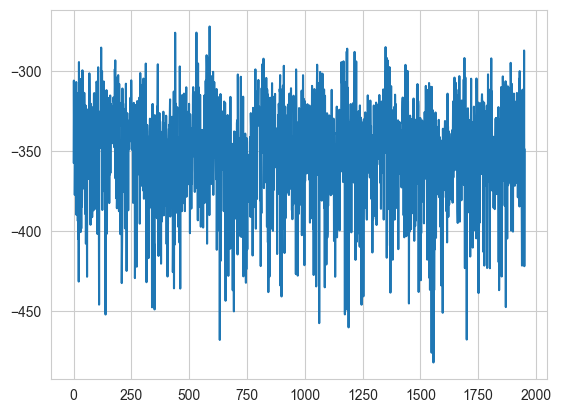

In [173]:
plt.plot(all_probs_random)

# Process snips

In [124]:
import numpy as np
from slang import dflt_snips_to_str
from odat.mdat.freesounds import mk_dacc

train_dacc = mk_dacc(audio_key='audio_train/', annots_key='train_post_competition.csv')

test_dacc = mk_dacc(audio_key='audio_test/', annots_key='test_post_competition.csv')

def load_pickle(filepath):
    import pickle
    with open(filepath, 'rb') as f:
        return pickle.load(f)
    
snipper = load_pickle('last_snipper.pkl') 

def process(wf):
    snips = np.array(list(snipper(wf)))
    snips_str = dflt_snips_to_str(snips)

    return snips_str


In [138]:
from odat.mdat.freesounds import FreesoundsDataset

In [151]:
import soundfile as sf
from io import BytesIO
from dol import FilesOfZip, add_ipython_key_completions, add_prefix_filtering, wrap_kvs



import soundfile as sf
from dol import FilesOfZip, wrap_kvs, filt_iter
from io import BytesIO



def my_obj_of_data(b):
    return sf.read(BytesIO(b), dtype="float32")[0]



#@wrap_kvs(obj_of_data=lambda b: sf.read(BytesIO(b), dtype="int16")[0])
@wrap_kvs(obj_of_data=my_obj_of_data)
@filt_iter(filt=lambda x: not x.startswith("__MACOSX") and x.endswith(".wav"))
class WfStore(FilesOfZip):
    """Waveform access. Keys are .wav filenames and values are numpy arrays of int16 waveform."""

    pass

In [ ]:
import hum 

dir(hum)

synthetic_wfs = hum.mk_audio_store(44100 * 3)

In [191]:
import pickle
synth_dict = load_pickle('data/slang_data/synthetic_wfs.pkl')

In [192]:
synth_dict

{'rand_1': array([ -600,  -813,  4592, ...,  2687, -1347,  -847], dtype=int16),
 'rand_2': array([-11905,   5205,   -881, ...,   8802,  10468,  -5778], dtype=int16),
 'rand_3': array([-21455, -22992,  21250, ...,   1107, -24332,   7400], dtype=int16),
 'pure_1': array([    0,  1902,  3797, ..., -3797, -1902,     0], dtype=int16),
 'pure_2': array([    0,  2689,  5356, ..., 25037, 23454, 21683], dtype=int16),
 'pure_3': array([    0,  3482,  6918, ..., 16485, 13463, 10260], dtype=int16),
 'triangle_1': array([-30000, -29900, -29800, ...,   -300,   -200,   -100], dtype=int16),
 'triangle_2': array([-30000, -29929, -29858, ...,  -7209,  -7138,  -7067], dtype=int16),
 'triangle_3': array([-30000, -29945, -29890, ..., -14270, -14215, -14160], dtype=int16),
 'square_1': array([ 30000,  30000,  30000, ..., -30000, -30000, -30000], dtype=int16),
 'square_2': array([ 30000,  30000,  30000, ..., -30000, -30000, -30000], dtype=int16),
 'square_3': array([ 30000,  30000,  30000, ..., -30000, -3000

In [152]:
extra_store = WfStore('/Users/sylvain/Desktop/dev/otosense/nanoGPT/data/slang_data/extra_data/Archive.zip')

In [190]:
selected_keys_train = list(train_dacc.wfs.keys())[:10]
selected_keys_test = list(test_dacc.wfs.keys())[:10]
selected_synth_keys = list(synth_dict.keys())

def mk_log_probas(keys, dacc):
    result = {}
    for key in keys:
        input_string = process(dacc[key])
        log_probas = moving_window_log_likelihoods(input_string, window_size=50, model=model)
        result[key]=log_probas
    return result



In [193]:
train_d = mk_log_probas(selected_keys_train, train_dacc.wfs)
test_d = mk_log_probas(selected_keys_test, test_dacc.wfs)
synth_d = mk_log_probas(selected_synth_keys, synth_dict)

In [159]:
other_d['noise.AirConditioner_2.9.1440000-1600000.wav.23q8e34o.ingestion-6bc8b65f8c-vrv59.wav']

array([-1.30784672, -1.30784672, -1.30784672, -1.30784672, -1.30784672,
       -1.30784672, -1.30784672, -1.30784672, -1.30784672, -1.30784672,
       -1.30784672, -1.30784672, -1.30784672, -1.30784672, -1.30784672,
       -1.30784672, -1.30784672, -1.30784672, -1.30784672, -1.30784672,
       -1.30784672, -1.30784672, -1.30784672, -1.30784672, -1.30784672,
       -1.30784672, -1.30784672, -1.30784672, -1.30784672])

In [194]:
import pandas as pd


def flatten(mylist):
    return [obj for sublist in mylist for obj in sublist]

df_train = pd.DataFrame()
df_train['train']=flatten([train_d[k] for k in train_d])
df_test = pd.DataFrame()
df_test['test']=flatten([test_d[k] for k in test_d])
df_random=pd.DataFrame()
df_random['random']=all_probs_random
df_synth=pd.DataFrame()
df_synth['synthetic']=flatten([synth_d[k] for k in synth_d])

<Axes: >

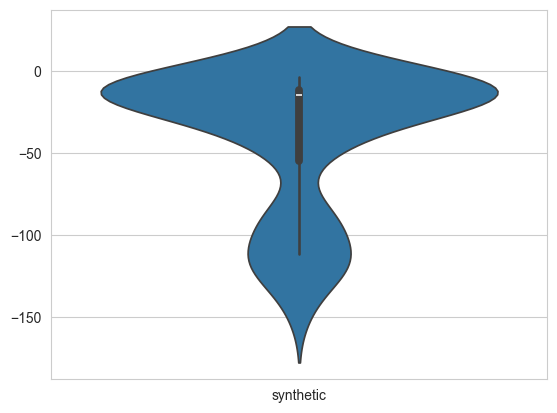

In [195]:
sns.violinplot(data=df_synth)

In [183]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def joint_violin_plot(*arrays, names=None):
    """
    Plots a joint violin plot for the given arrays.

    Parameters:
    - *arrays: Variable length argument list of arrays.
    - names: List of names for each distribution. If not provided, default names will be used.

    Returns:
    - None
    """
    # Check if names are provided, if not use default names
    if names is None:
        names = [f'Dist {i}' for i in range(1, len(arrays) + 1)]
    assert len(names) == len(arrays), "Number of names should match number of arrays."

    # Convert arrays to long-form DataFrame
    data = []
    for name, arr in zip(names, arrays):
        for val in arr:
            data.append({'Distribution': name, 'log_proba': val})
    df = pd.DataFrame(data)
    
    # Plot violin plot
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='Distribution', y='log_proba', data=df)
    plt.show()

# Example usage:
# arr1 = [0.1, 0.2, 0.3, 0.1, 0.2]
# arr2 = [0.5, 0.6, 0.7, 0.5, 0.6]
# arr3 = [0.8, 0.9, 0.85, 0.88]
# joint_violin_plot(arr1, arr2, arr3, names=['First', 'Second', 'Third'])


# Example usage:
# arr1 = [0.1, 0.2, 0.3, 0.1, 0.2]
# arr2 = [0.5, 0.6, 0.7, 0.5, 0.6]
# arr3 = [0.8, 0.9, 0.85, 0.88]
# joint_violin_plot(arr1, arr2, arr3)


/var/folders/mg/7pcn75bd72v46_l6x2yrrzdc0000gp/T/ipykernel_63159/171771536.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Distribution', y='log_proba', data=df, palette=colors)


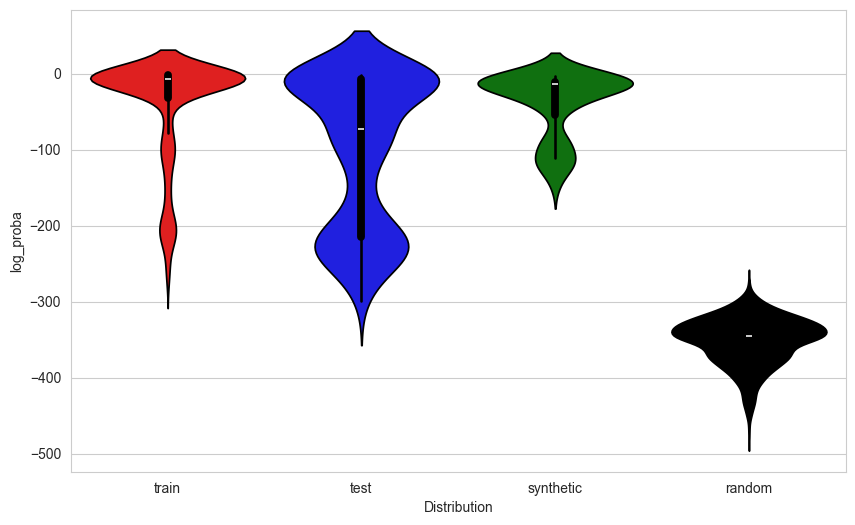

In [196]:
joint_violin_plot(flatten([train_d[k] for k in train_d]), flatten([test_d[k] for k in test_d]), flatten([synth_d[k] for k in synth_d]),all_probs_random, names=['train', 'test', 'synthetic','random'],colors=['red', 'blue', 'green','black'])

In [185]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def joint_violin_plot(*arrays, names=None, colors=None):
    """
    Plots a joint violin plot for the given arrays.

    Parameters:
    - *arrays: Variable length argument list of arrays.
    - names: List of names for each distribution. If not provided, default names will be used.
    - colors: List of colors for each distribution. If not provided, default colors will be used.

    Returns:
    - None
    """
    # Check if names are provided, if not use default names
    if names is None:
        names = [f'Dist {i}' for i in range(1, len(arrays) + 1)]
    assert len(names) == len(arrays), "Number of names should match number of arrays."
    
    # If colors are not provided, use default seaborn color palette
    if colors is None:
        colors = sns.color_palette("husl", len(arrays))

    # Convert arrays to long-form DataFrame
    data = []
    for name, arr in zip(names, arrays):
        for val in arr:
            data.append({'Distribution': name, 'log_proba': val})
    df = pd.DataFrame(data)
    
    # Plot violin plot
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='Distribution', y='log_proba', data=df, palette=colors)
    plt.show()

# Example usage:
# arr1 = [0.1, 0.2, 0.3, 0.1, 0.2]
# arr2 = [0.5, 0.6, 0.7, 0.5, 0.6]
# arr3 = [0.8, 0.9, 0.85, 0.88]
# joint_violin_plot(arr1, arr2, arr3, names=['First', 'Second', 'Third'], colors=['red', 'blue', 'green'])


<Axes: >

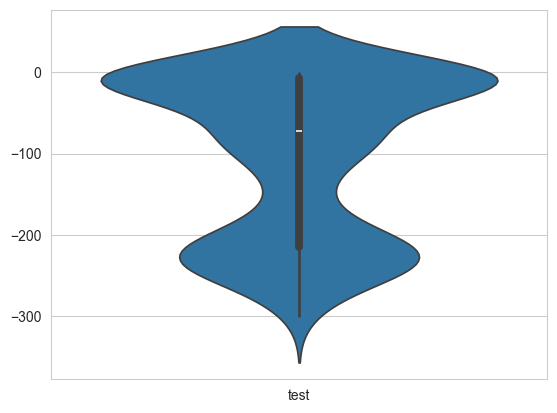

In [170]:
sns.violinplot(data=df_test)

In [130]:
import pickle

def save_dict_as_pickle(d, filename):
    """
    Saves a dictionary as a pickle file.

    Parameters:
    - d: Dictionary to be saved.
    - filename: Name of the pickle file.

    Returns:
    - None
    """
    with open(filename, 'wb') as file:
        pickle.dump(d, file)

# Example usage:
# my_dict = {"a": 1, "b": 2, "c": 3}
# save_dict_as_pickle(my_dict, 'my_dict.pkl')


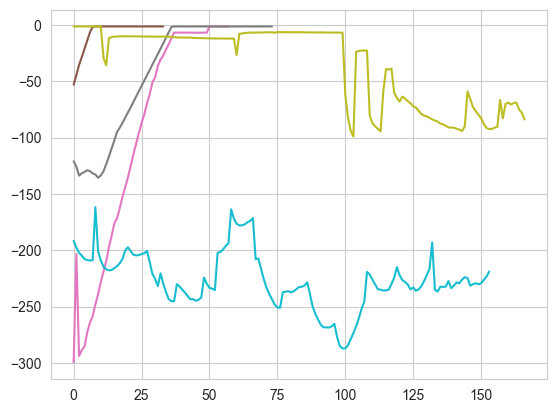

In [135]:
for k in d:
    plt.plot(d[k])

In [136]:
import pickle
save_dict_as_pickle(d, 'test_10_log_probas.p')

In [123]:
!pwd

/Users/sylvain/Desktop/dev/otosense/nanoGPT


In [ ]:
def process_file(filename):
    """
    Reads a .txt file line by line, applies the 'process' function to each line,
    and gathers the results into a list.

    Parameters:
    - filename: Path to the .txt file.

    Returns:
    - List of results after applying the 'process' function to each line.
    """
    results = []

    with open(filename, 'r') as file:
        for line in file:
            line = line.strip()  # Remove any leading/trailing whitespace
            result = process(line)
            results.append(result)

    return results

def process(line):
    # Sample 'process' function. Modify this according to your needs.
    return line.upper()

# Example usage:
# results = process_file('path_to_your_file.txt')
# print(results)


In [119]:
import matplotlib.pyplot as plt

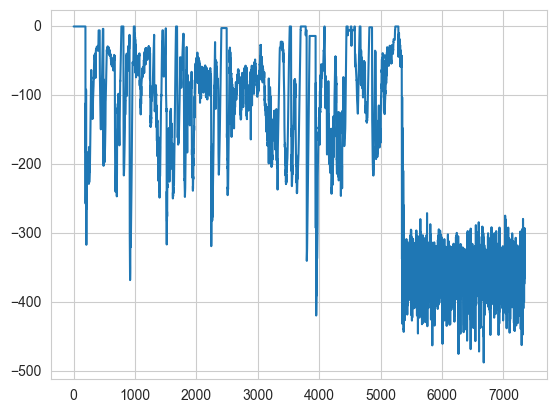

In [120]:
plt.plot(all_probs)

In [114]:
vars(model.config)

{'block_size': 64,
 'vocab_size': 206,
 'n_layer': 4,
 'n_head': 4,
 'n_embd': 128,
 'dropout': 0.0,
 'bias': False}

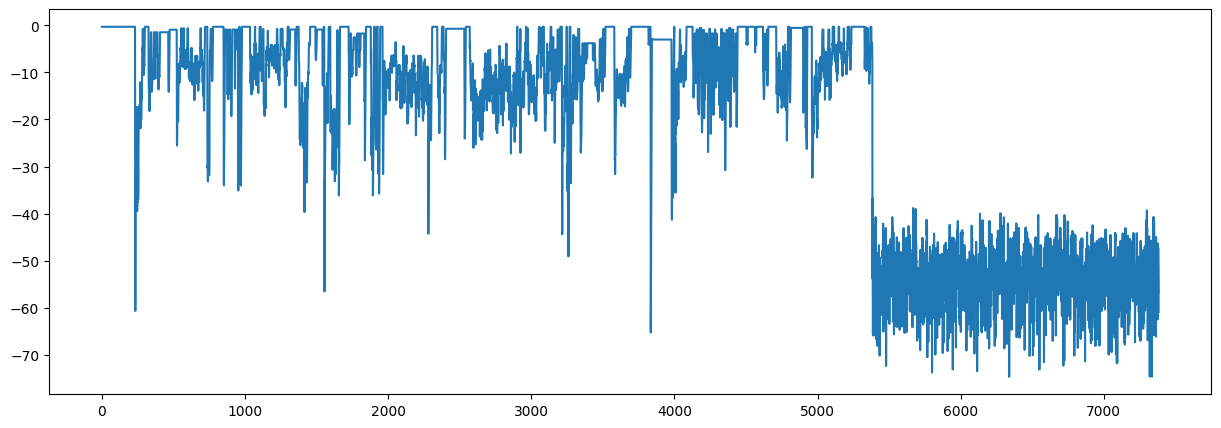

In [109]:
# Create a new figure with specified size (width=10 inches, height=5 inches)
fig, ax = plt.subplots(figsize=(15, 5))

# Example plot
ax.plot(all_probs)

# Display the plot
plt.show()

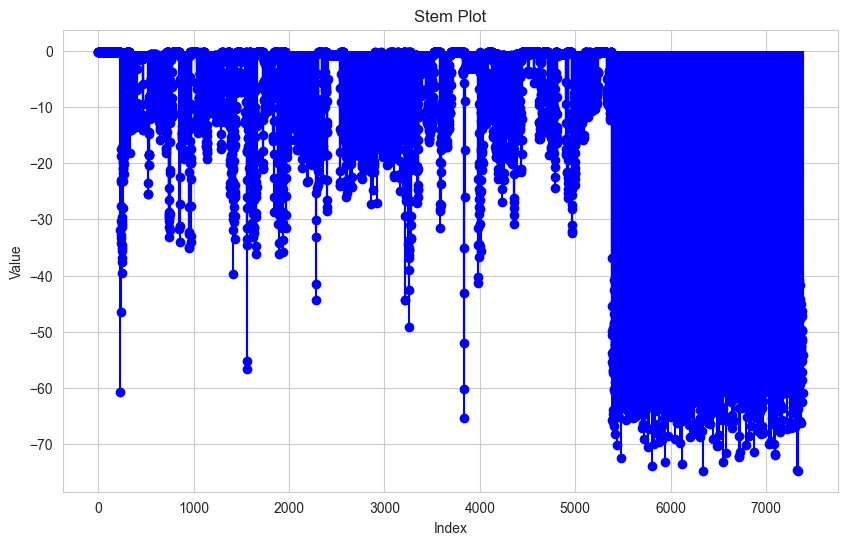

In [117]:
import numpy as np
import matplotlib.pyplot as plt

def stem_plot(data):
    """
    Create a stem plot for a given 1D array.
    
    Parameters:
    - data: 1D array or list of data points.
    """
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # Create a stem plot
    ax.stem(data, linefmt='-b', markerfmt='ob', basefmt=' ')

    # Set labels and title
    ax.set_title("Stem Plot")
    ax.set_ylabel("Value")
    ax.set_xlabel("Index")

    plt.show()

# Example usage:
data = [1.5, 3.2, 2.8, 4.1, 3.9, 2.4]
stem_plot(all_probs)


In [111]:
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 4.5 MB/s eta 0:00:00a 0:00:01


In [35]:
# Tokenize the input string
token_ids = encode(input_string)
token_ids = torch.tensor(token_ids).unsqueeze(0)  # Add batch dimension
#token_ids = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])
# Get logits from the model
logits, _ = model(token_ids)

# Convert logits to log probabilities
log_probs = F.log_softmax(logits, dim=-1)

# # Compute log likelihood of the input string
log_likelihood = 0.0
for i in range(1, len(token_ids[0])):
    log_likelihood += log_probs[0, i-1, token_ids[0, i]].item()

IndexError: index 1 is out of bounds for dimension 1 with size 1

In [44]:
import torch.nn.functional as F

def compute_log_likelihood(model, input_string):
    # Tokenize the input string
    start_ids = encode(input_string)
    #token_ids = torch.tensor(token_ids).unsqueeze(0)  # Add batch dimension
    token_ids = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])
    
    # Get the model's logits (predictions in log space)
    logits, _ = model(token_ids)
    
    # Convert logits to log probabilities
    log_probs = F.log_softmax(logits, dim=-1)
    
    # Convert the tensor to a simple list
    log_probs_list = log_probs.squeeze().tolist()
    
    # Compute the log likelihood of the input string
    #log_likelihood = sum([log_probs_list[i][token_id] for i, token_id in enumerate(token_ids[0][1:])])
    
    #return log_likelihood
    return log_probs_list

# Example usage:
log_likelihood = compute_log_likelihood(model, input_string)
# print(log_likelihood)


In [45]:
log_likelihood

[-5.950631141662598,
 -7.802065372467041,
 -13.482702255249023,
 -8.664899826049805,
 -8.303033828735352,
 -8.459487915039062,
 -8.544755935668945,
 -8.036310195922852,
 -8.63289737701416,
 -7.842120170593262,
 -13.253167152404785,
 -8.583927154541016,
 -9.431646347045898,
 -9.803473472595215,
 -9.308578491210938,
 -6.665337085723877,
 -8.988578796386719,
 -8.000788688659668,
 -10.165093421936035,
 -8.545632362365723,
 -9.102828979492188,
 -7.873270034790039,
 -10.757134437561035,
 -5.889583110809326,
 -7.671297073364258,
 -11.372381210327148,
 -6.976910591125488,
 -7.4980788230896,
 -7.716301918029785,
 -8.631196022033691,
 -11.004348754882812,
 -5.41005802154541,
 -10.959341049194336,
 -10.98293399810791,
 -7.680006504058838,
 -8.742183685302734,
 -11.81546688079834,
 -8.332889556884766,
 -8.378704071044922,
 -8.227534294128418,
 -0.15913772583007812,
 -8.025323867797852,
 -8.808104515075684,
 -9.910619735717773,
 -10.528595924377441,
 -10.060989379882812,
 -11.483312606811523,
 -8.3

In [30]:
log_probs.unsqueeze(0).tolist()

[[[[-5.950631141662598,
    -7.802065372467041,
    -13.482702255249023,
    -8.664899826049805,
    -8.303033828735352,
    -8.459487915039062,
    -8.544755935668945,
    -8.036310195922852,
    -8.63289737701416,
    -7.842120170593262,
    -13.253167152404785,
    -8.583927154541016,
    -9.431646347045898,
    -9.803473472595215,
    -9.308578491210938,
    -6.665337085723877,
    -8.988578796386719,
    -8.000788688659668,
    -10.165093421936035,
    -8.545632362365723,
    -9.102828979492188,
    -7.873270034790039,
    -10.757134437561035,
    -5.889583110809326,
    -7.671297073364258,
    -11.372381210327148,
    -6.976910591125488,
    -7.4980788230896,
    -7.716301918029785,
    -8.631196022033691,
    -11.004348754882812,
    -5.41005802154541,
    -10.959341049194336,
    -10.98293399810791,
    -7.680006504058838,
    -8.742183685302734,
    -11.81546688079834,
    -8.332889556884766,
    -8.378704071044922,
    -8.227534294128418,
    -0.15913772583007812,
    -8.0253

In [31]:
def compute_log_likelihood(model, input_string):
    # Tokenize the input string
    token_ids = encode(input_string)
    token_ids = torch.tensor(token_ids).unsqueeze(0)  # Add batch dimension

    # Get logits from the model
    logits, _ = model(token_ids)

    # Convert logits to log probabilities
    log_probs = F.log_softmax(logits, dim=-1)

    # Compute log likelihood of the input string
    log_likelihood = 0.0
    for i in range(1, len(token_ids[0])):
        log_likelihood += log_probs[0, i-1, token_ids[0, i]].item()

    return log_likelihood

# Example usage:
# Assuming you have a tokenizer for your GPT model
# log_likelihood = compute_log_likelihood(gpt_model, tokenizer, "Your input string here")
# print(log_likelihood)


In [32]:
log_likelihood = compute_log_likelihood(model, input_string)


IndexError: index 1 is out of bounds for dimension 1 with size 1

In [39]:
 len('-0123456789:ABCDEFGHIJKLMNOPQRSTUVWXYZ_abcdefghijklmnopqrstuvwxyzÀÁÂÃÄÅÆÇÈÉÊËÌÍÎÏÐÑÒÓÔÕÖ×ØÙÚÛÜÝÞßàáâãäåæçèéêëìíîïðñòóôõö÷øùúûüýþÿĀāĂăĄąĆćĈĉĊċČčĎďđĒēĔĕĖėĘęĚěĜĝĞğĠġĢ')


163

In [44]:
len([ 1.9307,  1.1828, -4.9455, -6.7650, -2.0055, -3.0020, -3.2038,
          -2.1942, -3.4653, -5.3109, -1.3434, -6.4464, -4.3917, -1.7048,
          -3.9408, -2.5360, -0.2636, -3.2607, -1.6355, -4.1500, -3.2615,
          -1.8201, -3.7380, -5.2553, -2.0990, -2.5190, -4.0043, -1.3846,
          -1.0009, -0.6828, -3.2038, -4.8597,  0.6266, -3.6161, -3.7216,
          -3.5843, -2.2755, -3.9846, -1.2852, -5.2079, -2.0455, -1.4619,
           7.0367, -1.5216, -2.4856, -1.1797, -4.4474, -2.2430, -2.2546,
          -1.4891, -3.5570, -1.2047, -0.2842, -1.8798, -1.3267, -0.4516,
          -0.3417, -1.5330, -0.9727, -1.6755, -1.9910, -0.4008, -3.8658,
          -0.5314, -4.6410, -4.1227, -3.5439, -2.0581,  0.0547, -2.5001,
          -2.9420,  1.0225, -3.5922, -1.3187, -2.2193, -2.8824, -0.0386,
          -1.0355,  2.4982, -2.7982, -3.4882, -2.1288, -4.7673, -3.3740,
          -4.7016, -1.5258, -2.0962, -0.2289, -2.7652, -3.6555, -1.3713,
          -2.5181, -1.3434, -0.2759, -3.8927, -2.8960, -0.3261, -2.5964,
          -3.0790, -1.6057, -1.8425,  0.1460, -0.9039, -1.5485, -2.4929,
          -4.3711, -2.3016, -3.5627, -1.1182, -1.6007, -5.1231, -3.0806,
          -3.0576, -3.7470, -0.2158,  0.8879, -3.2896, -3.9851, -1.7416,
          -4.9267, -3.5209, -3.3572, -3.2785, -2.6327, -2.5645,  0.6000,
          -2.1178, -2.6745, -3.9984, -2.7897, -5.0074, -2.7254, -2.7487,
          -0.3466, -4.4992, -0.7854, -2.5838, -2.0815, -2.9000, -2.7879,
          -2.9369, -3.7099, -3.8852, -4.8258, -2.3163, -0.2856, -4.1565,
          -2.2483, -6.9151, -0.5414, -1.7882, -3.6384,  0.8883, -2.1491,
          -1.3721, -2.1947, -5.2771, -1.9821, -2.4926, -1.6949, -6.6289,
          -6.0050, -3.1536, -3.2256, -2.5102])

165

In [46]:
from torch.nn import functional as F

probs = F.softmax(logits, dim=-1)
probs

tensor([[[5.7558e-03, 2.7246e-03, 5.9401e-06, 9.6299e-07, 1.1237e-04,
          4.1483e-05, 3.3901e-05, 9.3039e-05, 2.6101e-05, 4.1220e-06,
          2.1785e-04, 1.3243e-06, 1.0335e-05, 1.5179e-04, 1.6223e-05,
          6.6106e-05, 6.4140e-04, 3.2027e-05, 1.6268e-04, 1.3161e-05,
          3.2000e-05, 1.3526e-04, 1.9872e-05, 4.3579e-06, 1.0234e-04,
          6.7239e-05, 1.5225e-05, 2.0907e-04, 3.0684e-04, 4.2175e-04,
          3.3900e-05, 6.4727e-06, 1.5622e-03, 2.2447e-05, 2.0200e-05,
          2.3172e-05, 8.5773e-05, 1.5528e-05, 2.3091e-04, 4.5693e-06,
          1.0796e-04, 1.9351e-04, 9.4975e-01, 1.8230e-04, 6.9526e-05,
          2.5662e-04, 9.7757e-06, 8.8614e-05, 8.7593e-05, 1.8832e-04,
          2.3814e-05, 2.5027e-04, 6.2835e-04, 1.2741e-04, 2.2153e-04,
          5.3147e-04, 5.9324e-04, 1.8024e-04, 3.1563e-04, 1.5630e-04,
          1.1401e-04, 5.5915e-04, 1.7487e-05, 4.9069e-04, 8.0545e-06,
          1.3525e-05, 2.4127e-05, 1.0661e-04, 8.8177e-04, 6.8520e-05,
          4.4045e-05

In [43]:
# check the measure of error for produced message, used in NLP
# change the size of window ("last few chars"): 5, 10, 20,? ****
# display the matrix of logits
# what to do to see how well can we do anomalies with that? feed some never seen sounds, or change 
# categories: music vs voice? 
# how is it at edge detection: silence vs noise? then prediction of what happens next? when the silence ends
# example: baby cried longer than usual
# trick where you use these numbers as an embedding (see word2vec, snip2vec): we project things
# to that dimension, use it as a featurizer for a normal predictor (eg classification)
logits

tensor([[[ 1.9307,  1.1828, -4.9455, -6.7650, -2.0055, -3.0020, -3.2038,
          -2.1942, -3.4653, -5.3109, -1.3434, -6.4464, -4.3917, -1.7048,
          -3.9408, -2.5360, -0.2636, -3.2607, -1.6355, -4.1500, -3.2615,
          -1.8201, -3.7380, -5.2553, -2.0990, -2.5190, -4.0043, -1.3846,
          -1.0009, -0.6828, -3.2038, -4.8597,  0.6266, -3.6161, -3.7216,
          -3.5843, -2.2755, -3.9846, -1.2852, -5.2079, -2.0455, -1.4619,
           7.0367, -1.5216, -2.4856, -1.1797, -4.4474, -2.2430, -2.2546,
          -1.4891, -3.5570, -1.2047, -0.2842, -1.8798, -1.3267, -0.4516,
          -0.3417, -1.5330, -0.9727, -1.6755, -1.9910, -0.4008, -3.8658,
          -0.5314, -4.6410, -4.1227, -3.5439, -2.0581,  0.0547, -2.5001,
          -2.9420,  1.0225, -3.5922, -1.3187, -2.2193, -2.8824, -0.0386,
          -1.0355,  2.4982, -2.7982, -3.4882, -2.1288, -4.7673, -3.3740,
          -4.7016, -1.5258, -2.0962, -0.2289, -2.7652, -3.6555, -1.3713,
          -2.5181, -1.3434, -0.2759, -3.8927, -2.89

In [33]:
with torch.no_grad():
    with ctx:
        for k in range(num_samples):
            y = model.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)
            print(decode(y[0].tolist()))
            print('---------------')

abbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbËËËËËËËËËËËËËËËËËËËËËbbbbbbËËËËËËËbbbbËËËËËËËËËËËËËËËËËËËËËËËËËËËËËbbËËËËËËËËËËËËËbbËËËbËËËËËÚËËËËËbbËËbËËËËËËËbËËËËËËËËËËËËËËbËËËËËËbËÔËËËbËËËËËbËËËËËbËËËËËËËËËËbbËËËËËËËËbËËËËbËËËËËËËËËËËËËËËËËËËËËËËËÆËËËËËËËËbbbËËËËËËbbbbËËËËËËËËËbbbbbËËËËËËËËËbbbbbbbbËËËËbbbbËËËbbbbËËËËËËËËËËËËbËËËËËËËËËËËËËËËËËbËËËËËËËËËËËË
---------------
abbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbËÉÉÉËbbbbËËbbbbbËËËËËËËËbbËËËËËËËbbbbbËËËËËbbbbbËÉË

In [34]:
model.state_dict()

OrderedDict([('transformer.wte.weight',
              tensor([[-5.0581e-02, -4.2051e-02, -8.0691e-02,  ...,  4.8803e-02,
                        2.3874e-02, -3.5259e-02],
                      [ 4.7397e-05,  8.8309e-02,  1.1242e-01,  ...,  1.1734e-01,
                        5.2131e-02,  3.6257e-02],
                      [ 8.7407e-02, -1.4090e-02,  4.2185e-02,  ...,  1.2650e-01,
                       -7.7602e-02, -8.1872e-02],
                      ...,
                      [-3.9811e-02,  4.0846e-02, -6.2443e-02,  ..., -7.2490e-03,
                       -9.5569e-03, -6.4395e-02],
                      [-4.8087e-02,  3.5425e-03, -8.7879e-02,  ..., -6.5736e-02,
                        7.4864e-02,  4.1747e-02],
                      [ 5.8965e-02, -3.6151e-02,  8.3334e-02,  ...,  9.0242e-03,
                       -3.5748e-02, -5.6006e-02]])),
             ('transformer.wpe.weight',
              tensor([[-0.0238, -0.0416,  0.0019,  ..., -0.0441,  0.0381,  0.0108],
                    

In [27]:
vars(model)

{'training': False,
 '_parameters': OrderedDict(),
 '_buffers': OrderedDict(),
 '_non_persistent_buffers_set': set(),
 '_backward_pre_hooks': OrderedDict(),
 '_backward_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_forward_hooks': OrderedDict(),
 '_forward_hooks_with_kwargs': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_forward_pre_hooks_with_kwargs': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_post_hooks': OrderedDict(),
 '_modules': OrderedDict([('transformer',
               ModuleDict(
                 (wte): Embedding(165, 128)
                 (wpe): Embedding(64, 128)
                 (drop): Dropout(p=0.0, inplace=False)
                 (h): ModuleList(
                   (0-3): 4 x Block(
                     (ln_1): LayerNorm()
                     (attn): CausalSelfAttention(
                       (c_attn): Linear(in_features=128, out_fe

In [28]:
model.state_dict

<bound method Module.state_dict of GPT(
  (transformer): ModuleDict(
    (wte): Embedding(165, 128)
    (wpe): Embedding(64, 128)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-3): 4 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=128, out_features=384, bias=False)
          (c_proj): Linear(in_features=128, out_features=128, bias=False)
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=128, out_features=512, bias=False)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=512, out_features=128, bias=False)
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=128, out_features=165, bias=False)
)>

In [29]:
model(0)

AttributeError: 'int' object has no attribute 'device'

# Get the snips

In [4]:
from dol import FilesOfZip
# https://zenodo.org/records/2552860#.Xhdyj78o-V4
s = FilesOfZip('/Users/Sylvain/Dropbox/kaggle/freesound/FSDKaggle2018.audio_train.zip')


In [5]:
list(s.keys())[:3]

['FSDKaggle2018.audio_train/00044347.wav',
 'FSDKaggle2018.audio_train/001ca53d.wav',
 'FSDKaggle2018.audio_train/002d256b.wav']

In [6]:
from dol import wrap_kvs
import pandas as pd
from io import BytesIO
import soundfile as sf

def deserialize_wrt_suffix(self, k, v, assert_sr=44100):
    if k.endswith('.csv'):
        return pd.read_csv(BytesIO(v))
    elif k.endswith('.wav'):
        wf, sr = sf.read(BytesIO(v), dtype='int16')
        assert sr == assert_sr, f"samplerate of {k} was not {assert_sr}"
        return wf
    else:
        return v

In [7]:
KaggleMeta = wrap_kvs(FilesOfZip, name='KaggleMeta', postget=deserialize_wrt_suffix)


In [8]:
data = KaggleMeta('/Users/Sylvain/Dropbox/kaggle/freesound/FSDKaggle2018.audio_train.zip')
metadata = KaggleMeta('/Users/Sylvain/Dropbox/kaggle/freesound/FSDKaggle2018.meta.zip')

In [12]:
list(metadata.keys())[:3]

['FSDKaggle2018.meta/test_post_competition_scoring_clips.csv',
 'FSDKaggle2018.meta/train_post_competition.csv']

In [14]:
metadata['FSDKaggle2018.meta/train_post_competition.csv']

,fname,label,manually_verified,freesound_id,license
0,00044347.wav,Hi-hat,0,28739,Attribution
1,001ca53d.wav,Saxophone,1,358827,Attribution
2,002d256b.wav,Trumpet,0,10897,Creative Commons 0
3,0033e230.wav,Glockenspiel,1,325017,Attribution
4,00353774.wav,Cello,1,195688,Attribution
...,...,...,...,...,...
9468,ffec59fb.wav,Fireworks,0,343090,Creative Commons 0
9469,fff37590.wav,Hi-hat,0,33136,Attribution
9470,fff44ac6.wav,Laughter,0,133674,Attribution
9471,fff6a13d.wav,Chime,0,14640,Attribution


# Scrap

In [47]:
from omodel.core.spectro import get_wf_to_spectr_func
_spectr_of_wf = get_wf_to_spectr_func()
spectr_of_wf = lambda wf: _spectr_of_wf(wf).T

def wf_tag_gen(df, name_to_wf, name_field='fname', tag_field='label'):
    for name, tag in zip(train_df.fname, train_df.label):
        yield name_to_wf(name), tag
    
def spectr_tag_gen(wf_tags, spectr_of_wf=spectr_of_wf):
    for wf, tag in wf_tags:
        for x in spectr_of_wf(wf):
            yield list(x), tag
            
wf_tags = wf_tag_gen(train_df, lambda name: ka[f'audio_train/{name}'])
spectr_tags = spectr_tag_gen(wf_tags)

In [ ]:
def wf_tag_gen(df, name_to_wf, name_field='fname', tag_field='label'):
    for name, tag in zip(train_df.fname, train_df.label):
        yield name_to_wf(name), tag
    
def spectr_tag_gen(wf_tags, spectr_of_wf=spectr_of_wf):
    for wf, tag in wf_tags:
        for x in spectr_of_wf(wf):
            yield list(x), tag
            
wf_tags = wf_tag_gen(train_df, lambda name: ka[f'audio_train/{name}'])
spectr_tags = spectr_tag_gen(wf_tags)

In [51]:
from slang import KvDataSource, Snipper, ClassificationSnipper, fixed_step_chunker, ddir, dflt_snips_to_str

from slang import ClassificationSnipper

ImportError: cannot import name 'KvDataSource' from 'slang' (unknown location)

In [ ]:
snipper = ClassificationSnipper(wf_to_chks={'chk_size': 2048}, 
                                chk_to_fv={'n_components': 2}, 
                                fv_to_snip={'n_clusters': 5})
snipper.fit_fv_to_snip(train_XX, train_yy)

train_snips = np.array([snipper.fv_to_snip(fv) for fv in train_XX])
test_snips = np.array([snipper.fv_to_snip(fv) for fv in test_XX])

In [1]:
from odat.mdat.freesounds import mk_dacc
'/Users/sylvain/Dropbox/kaggle/freesound/freesounds_audio_dataset.zip'

ImportError: cannot import name 'MyType' from 'atypes' (unknown location)

In [ ]:
/Users/sylvain/Dropbox/kaggle/freesound/freesounds_audio_dataset.zip

In [3]:
from config2py import config_getter

zip_filepath = config_getter('freesounds_audio_dataset_local_zip_filepath')